# **Fase exploratória**

In [30]:
import sys
import os
sys.path.append(os.path.abspath("../.."))


from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Exploratory Analysis

## Parte 1: carregando os dados


### **Split Estratificado (fixo)**

In [31]:
df_train_split = pd.read_csv(
    '../../datasets/base_vertical/train/train_stratified.csv')
df_val_split = pd.read_csv(
    '../../datasets/base_vertical/val/val_stratified.csv')
df_test_split = pd.read_csv(
    '../../datasets/base_vertical/test/test_stratified.csv')

# separação X / y
# X_train_split = df_train_split.drop(
#     columns=['Heart Sound Type_Normal', 'Heart Sound ID'])
# y_train_split = df_train_split['Heart Sound Type_Normal']
# X_val_split = df_val_split.drop(
#     columns=['Heart Sound Type_Normal', 'Heart Sound ID'])
# y_val_split = df_val_split['Heart Sound Type_Normal']
# X_test_split = df_test_split.drop(
#     columns=['Heart Sound Type_Normal', 'Heart Sound ID'])
# y_test_split = df_test_split['Heart Sound Type_Normal']

#### Normalização (aprender no treino, aplicar nos outros)

In [70]:
# scaler_split = StandardScaler()
# X_train_split_scaled = scaler_split.fit_transform(X_train_split)
# X_val_split_scaled = scaler_split.transform(X_val_split)
# X_test_split_scaled = scaler_split.transform(X_test_split)

###  **Para os folds (K-Fold)**

In [32]:
base_path = Path('../../datasets/base_vertical/groupkfold')
folds = []
df_folds =[]

for i in range(1, 6):
    df_train_fold = pd.read_csv(base_path / f'fold_{i}' / 'train.csv')
    df_val_fold = pd.read_csv(base_path / f'fold_{i}' / 'val.csv')

    Xf_train = df_train_fold.drop(
        columns=['Heart Sound Type_Normal', 'Heart Sound ID'])
    yf_train = df_train_fold['Heart Sound Type_Normal']
    Xf_val = df_val_fold.drop(
        columns=['Heart Sound Type_Normal', 'Heart Sound ID'])
    yf_val = df_val_fold['Heart Sound Type_Normal']

    scaler_fold = StandardScaler()
    Xf_train_scaled = scaler_fold.fit_transform(Xf_train)
    Xf_val_scaled = scaler_fold.transform(Xf_val)

    folds.append({
        'fold': i,
        'df_train': df_train_fold,
        'df_val': df_val_fold,
        'X_train': Xf_train_scaled,
        'y_train': yf_train,
        'X_val': Xf_val_scaled,
        'y_val': yf_val
    })

## Parte 2: Exploração

### Describe Variables

Calcular estatísticas descritivas básicas (`count`, `mean`, `std`, `min`, `25%`, `50%`, `75%`, `max`) para todas as colunas numéricas.

"Quais variáveis mais variam entre as janelas?"

In [33]:
df_train_split.info()
del df_train_split['Heart Sound ID']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 87 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Heart Sound ID                          600 non-null    object 
 1   window_id                               600 non-null    int64  
 2   freq_mean                               600 non-null    float64
 3   centro_x_mean                           600 non-null    float64
 4   centro_y_mean                           600 non-null    float64
 5   raio_medio_mean                         600 non-null    float64
 6   raio_std_mean                           600 non-null    float64
 7   raio_max_mean                           600 non-null    float64
 8   raio_min_mean                           600 non-null    float64
 9   simetria_x_mean                         600 non-null    float64
 10  simetria_y_mean                         600 non-null    float6

In [27]:
desc = df_train_split.describe().T.sort_values("std", ascending=False)
desc

count          mean           std          min  \
auto_intersecoes_mean   600.0  68469.684504  1.131164e+05  3591.981481   
auto_intersecoes_std    600.0    727.363482  8.279707e+02    40.847698   
mfcc_0_mean             600.0   -103.157517  5.329197e+01  -326.816616   
comprimento_curva_mean  600.0     97.550976  4.182367e+01     6.669564   
freq_mean               600.0     87.336991  3.721410e+01    37.388393   
...                       ...           ...           ...          ...   
rqa_rqa_threshold_mean  600.0      0.100000  9.769430e-16     0.100000   
rqa_fs_mean             600.0    800.000000  0.000000e+00   800.000000   
rqa_delay_mean          600.0      2.000000  0.000000e+00     2.000000   
rqa_embedding_dim_mean  600.0      5.000000  0.000000e+00     5.000000   
rms_energy_std          600.0      0.000000  0.000000e+00     0.000000   

                                 25%           50%           75%           max  
auto_intersecoes_mean   24532.081357  43168.969737  68541.591611  1.078025e+06  
auto_intersecoes_std      223.829637    302.310003    750.278057  3.572562e+03  
mfcc_0_mean              -126.091467    -99.952397    -76.057449 -2.109173e+00  
comprimento_curva_mean     69.925640     87.720155    116.699732  2.475706e+02  
freq_mean                  62.002366     74.353056    110.048718  1.970731e+02  
...                              ...           ...           ...           ...  
rqa_rqa_threshold_mean      0.100000      0.100000      0.100000  1.000000e-01  
rqa_fs_mean               800.000000    800.000000    800.000000  8.000000e+02  
rqa_delay_mean              2.000000      2.000000      2.000000  2.000000e+00  
rqa_embedding_dim_mean      5.000000      5.000000      5.000000  5.000000e+00  
rms_energy_std              0.000000      0.000000      0.000000  0.000000e+00  

[86 rows x 8 columns]

Variáveis com maior variabilidade (alto desvio padrão (`std`))

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `auto_intersecoes_mean`  | Varia muito de janela pra janela → sinal de **alta complexidade geométrica**          |
| `mfcc_0_mean`            | É a energia espectral global (1º coef. cepstral) → **bom sinal** que ele varia        |
| `comprimento_curva_mean` | Relacionado a densidade da winding → diferencia sons mais “longos” ou “curtos”        |
| `freq_mean`              | Frequência dominante média da janela → variação natural esperada em sons fisiológicos |

Ou seja, essas são as _features_  mais "vivas" do nosso dataset, as que provavelmente poderão ajudar os modelos a distinguir entre as classes.

Enquanto isso, as _features_ com menos variabilidade (desvio padrão (`std=0`)) são 

| Variável                 | Interpretação                                                                         |
| ------------------------ | ------------------------------------------------------------------------------------- |
| `rqa_fs_mean	`           | Pois tem o valor fixo de 800. Taxa de amostragem usada no RQA, é esperada como constante         |
| `rqa_delay_mean`         | Valor fixo  =  2. Delay usado no embedding, fixado como hiperparâmetro, normal       |
| `rqa_embedding_dim_mean` | Dimensão do embedding, também fixada no código, esperado        |
| `rms_energy_std`         | Porque a energia já foi calculada uma única vez por janela.|

Ou seja, nenhuma dessas colunas com variabilidade nula apresentam alguma inconsistência até então, mas não são informativas para modelos de aprendizado supervisionado por não terem variação e não contribuirem para separação de classes.



In [6]:
columns_to_remove = ['rqa_fs_mean', 
                             'rqa_delay_mean', 
                             'rqa_embedding_dim_mean', 
                             'rms_energy_std', 
                             'Gender_M', 
                             'Heart Sound ID']
df_train_split = df_train_split.drop(columns=columns_to_remove)

### ANOVA entre classes (usando argmax da codificação one-hot como label)

ANOVA - Analysis of Variance

Um teste estatístico que responde à pergunta:

“Essa variável é diferente entre os grupos (classes) ou não?”

In [13]:
anova_binaria = {}

y = df_train_split["Heart Sound Type_Normal"]

top_vars = desc.head(22).index.tolist()


for var in top_vars:
    grupo_normal = df_train_split[df_train_split["Heart Sound Type_Normal"] == 1][var].dropna(
    )
    grupo_anormal = df_train_split[df_train_split["Heart Sound Type_Normal"]
                               == 0][var].dropna()

    if len(grupo_normal) >= 2 and len(grupo_anormal) >= 2:
        try:
            pval = f_oneway(grupo_normal, grupo_anormal).pvalue
            anova_binaria[var] = pval
        except Exception as e:
            print(f"Erro com {var}: {e}")
    else:
        print(f"Variável ignorada: {var} (amostras insuficientes)")

# Ordena por p-valor (menor = mais discriminativo)
anova_binaria_sorted = dict(sorted(anova_binaria.items(), key=lambda x: x[1]))

In [14]:
anova_binaria_sorted

{'mfcc_11_mean': np.float64(5.437605647446237e-20),
 'mfcc_5_mean': np.float64(2.96932286321955e-13),
 'mfcc_6_mean': np.float64(3.1658276712921523e-12),
 'mfcc_10_mean': np.float64(5.981709426162654e-10),
 'mfcc_12_mean': np.float64(8.641415616517434e-10),
 'mfcc_2_mean': np.float64(2.241567779230638e-09),
 'mfcc_3_mean': np.float64(1.2256220999315055e-08),
 'spectral_centroid_mean': np.float64(2.747578054593789e-07),
 'freq_std': np.float64(4.519426275911533e-06),
 'freq_mean': np.float64(5.039997614192798e-05),
 'rqa_longest_diagonal_line_mean': np.float64(0.0020929396354588273),
 'mfcc_8_mean': np.float64(0.004228675269783627),
 'auto_intersecoes_std': np.float64(0.005769008520704557),
 'mfcc_1_mean': np.float64(0.031397223448434305),
 'kurtosis_mean': np.float64(0.04558969921192295),
 'mfcc_9_mean': np.float64(0.07157410017936437),
 'comprimento_curva_mean': np.float64(0.1455555736361532),
 'mfcc_0_mean': np.float64(0.23176025119754018),
 'auto_intersecoes_mean': np.float64(0.3936

### Correlograma das 22 principais variáveis

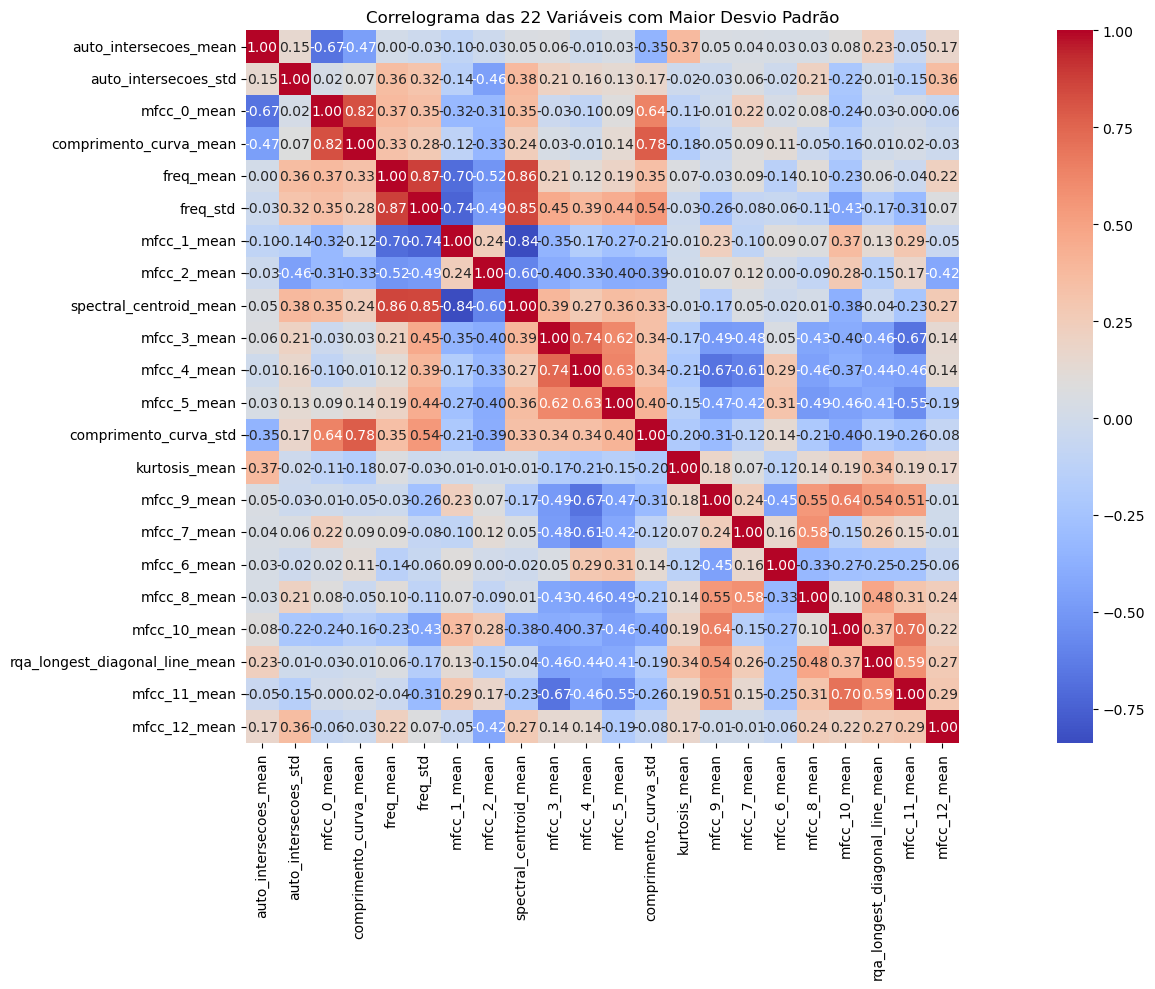

In [15]:
desc = df_train_split.describe().T.sort_values("std", ascending=False)
corr = df_train_split[top_vars].corr()

plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)

plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")

plt.tight_layout()

plt.show()

In [89]:
columns_to_remove = ['comprimento_curva_std', 'freq_std' ]
df_train_split = df_train_split.drop(columns=columns_to_remove)

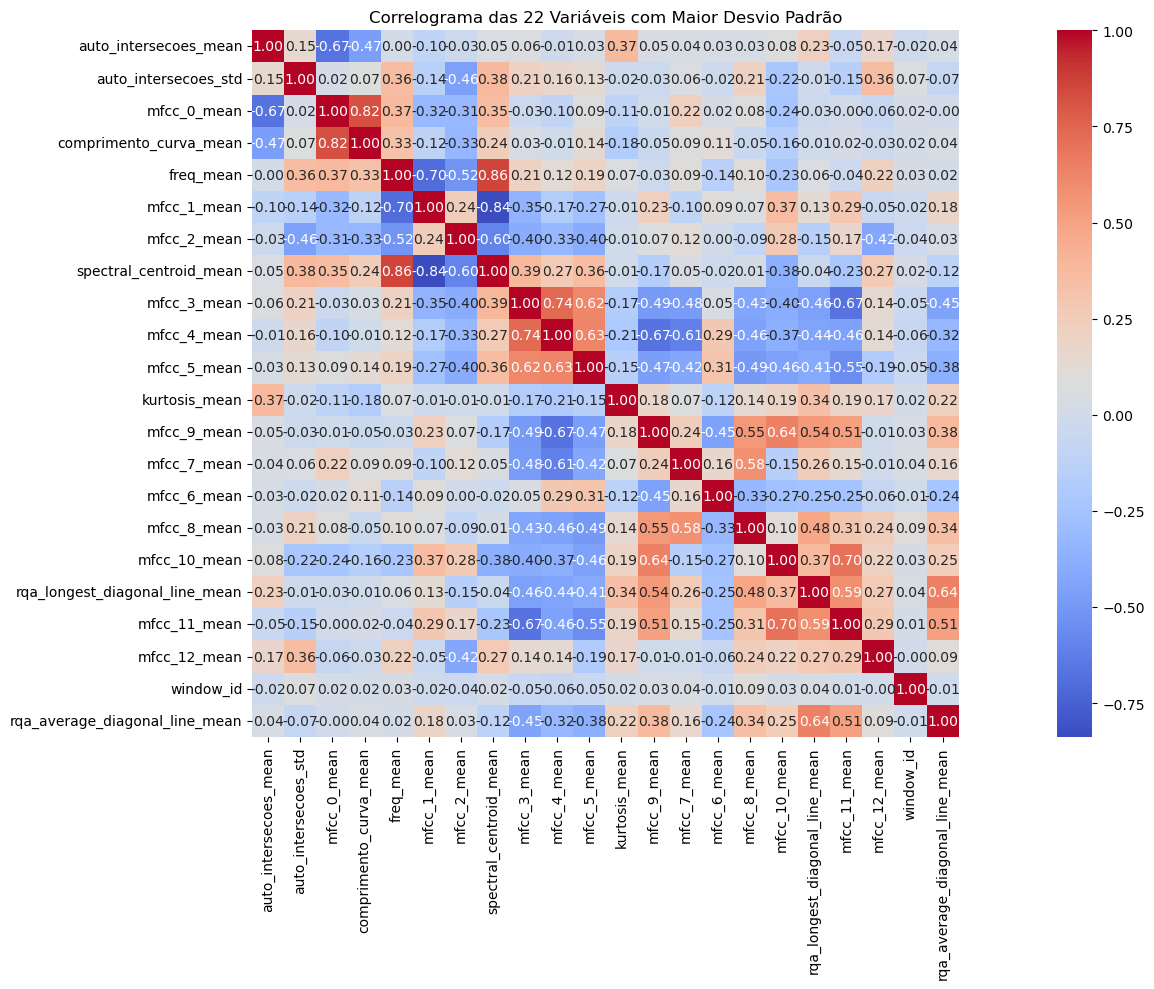

In [92]:
# Novo correlograma após a limpeza

desc = df_train_split.describe().T.sort_values("std", ascending=False)
top_vars = desc.head(22).index.tolist()

corr = df_train_split[top_vars].corr()

plt.figure(figsize=(20, 10))

sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)

plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")

plt.tight_layout()

plt.show()

### Distribuição de classes no split fixo


Distribuição de classes no split fixo


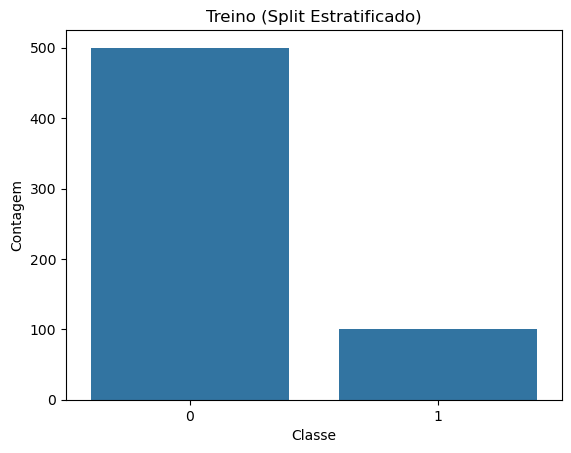

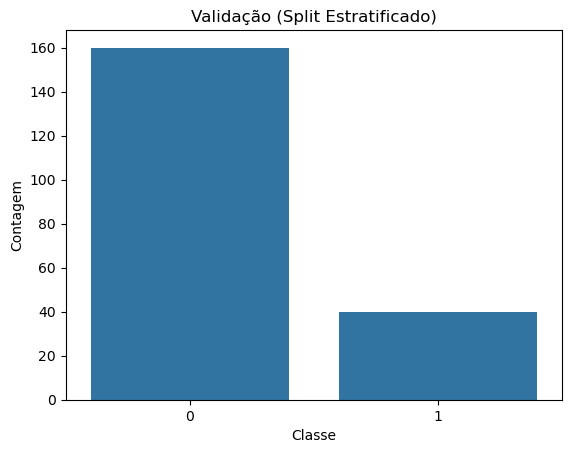

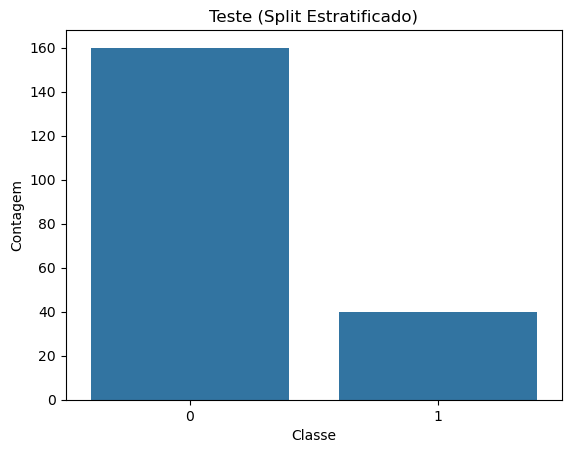

In [14]:
def plot_class_distribution(y, title):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Classe')
    plt.ylabel('Contagem')
    plt.show()

print("\nDistribuição de classes no split fixo")
plot_class_distribution(y_train_split, "Treino (Split Estratificado)")
plot_class_distribution(y_val_split, "Validação (Split Estratificado)")
plot_class_distribution(y_test_split, "Teste (Split Estratificado)")


### Distribuição de classes por fold


Distribuição de classes nos folds k-fold
Fold 1 - Treino


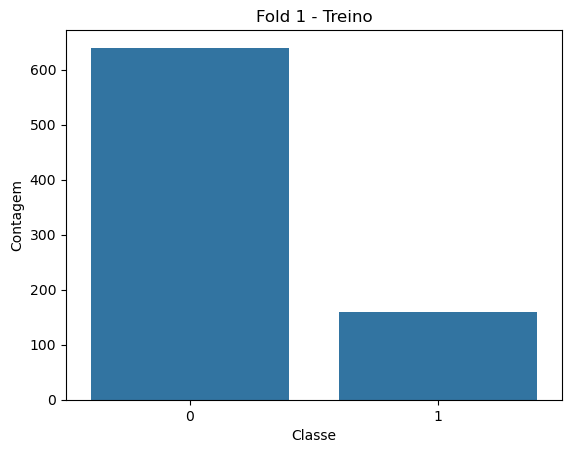

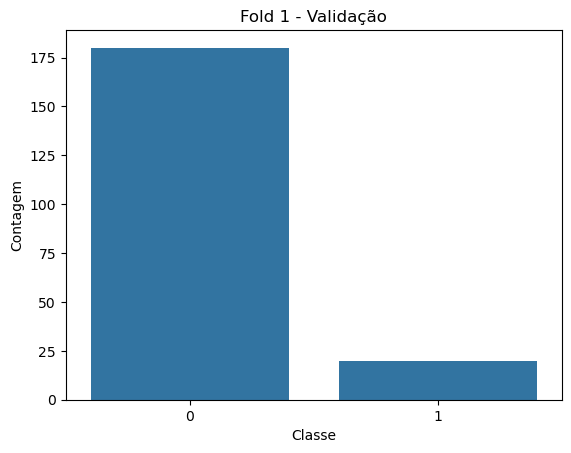

Fold 2 - Treino


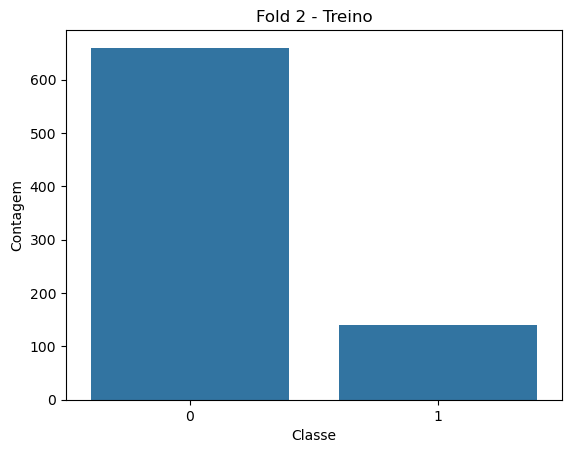

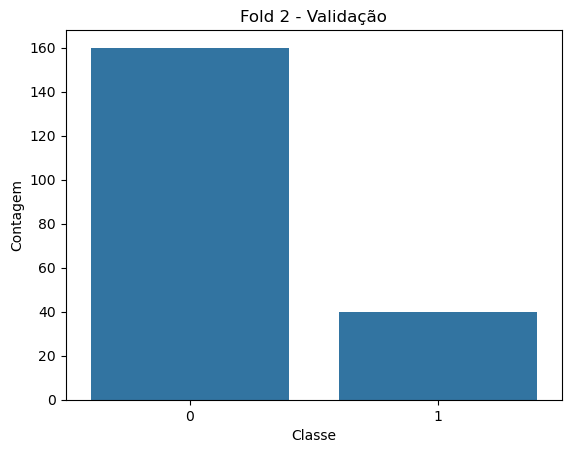

Fold 3 - Treino


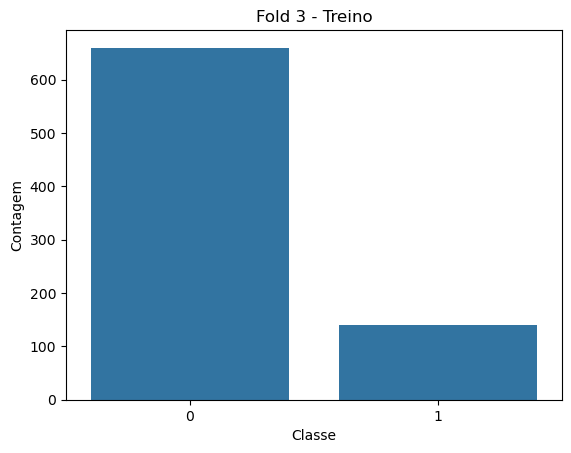

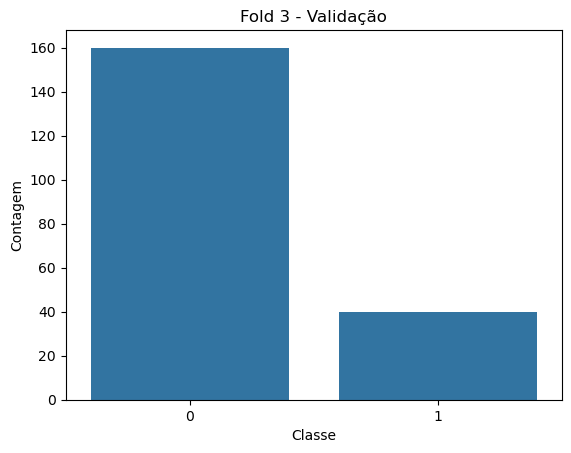

Fold 4 - Treino


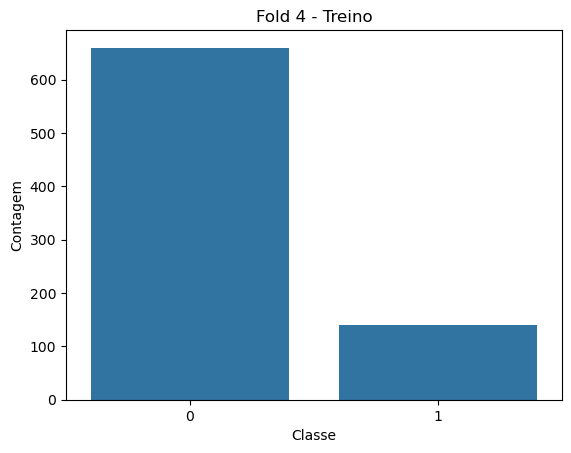

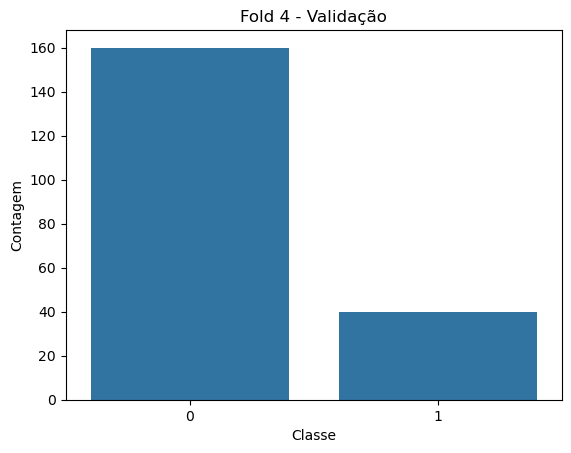

Fold 5 - Treino


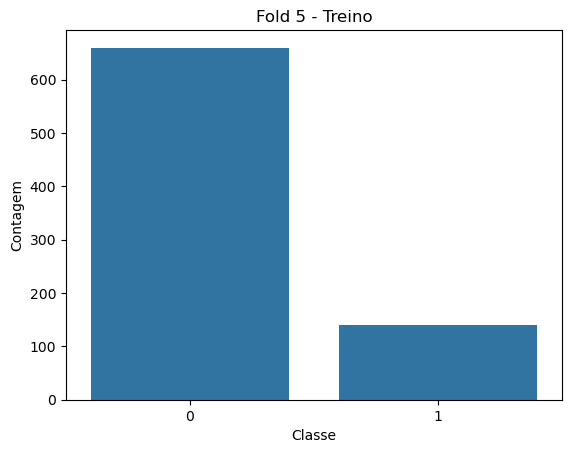

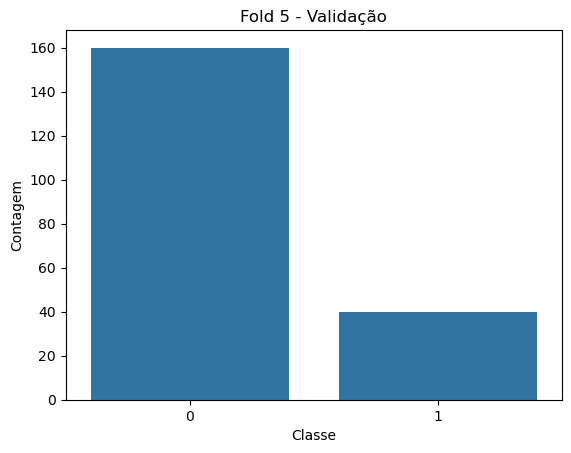

In [13]:
print("\nDistribuição de classes nos folds k-fold")
for fold in folds:
    print(f"Fold {fold['fold']} - Treino")
    plot_class_distribution(fold['y_train'], f"Fold {fold['fold']} - Treino")
    plot_class_distribution(fold['y_val'], f"Fold {fold['fold']} - Validação")

### **SEPARAÇÃO NÃO-LINEAR**

O PCA (Principal Component Analysis) reduz a dimensionalidade do dataset projetando os dados em componentes principais que preservam a **variância máxima**. É útil para visualizar a estrutura global dos dados. O t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica não-linear que foca em preservar **relações locais** entre os pontos. É mais adequado quando queremos identificar **aglomerados ou separações sutis** entre as classes.

#### PCA para visualização em 2D (split fixo)

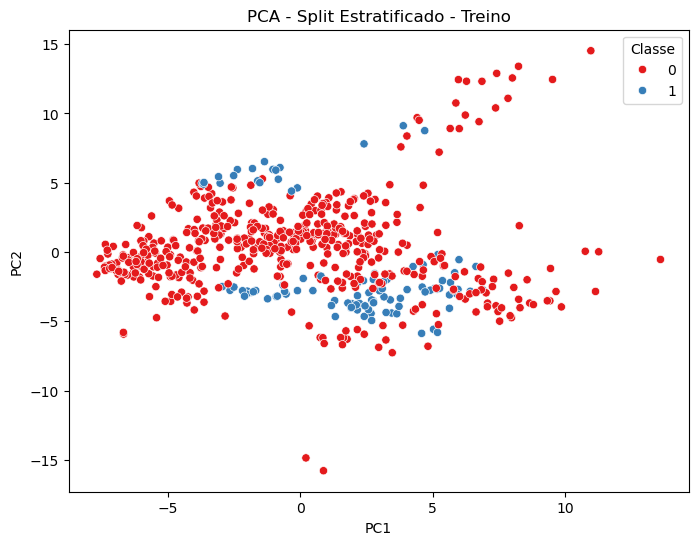

In [64]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_split_scaled)

plt.figure(figsize=(8, 6))
plt.title("PCA - Split Estratificado - Treino")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=y_train_split, palette="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Classe")
plt.show()

#### PCA por fold

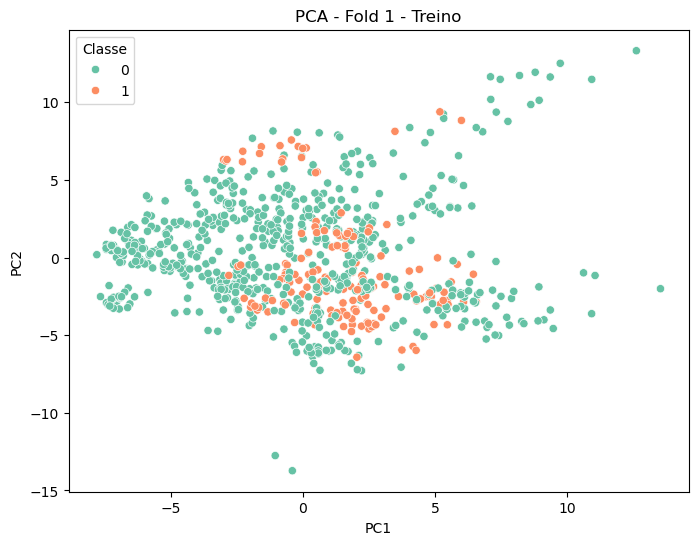

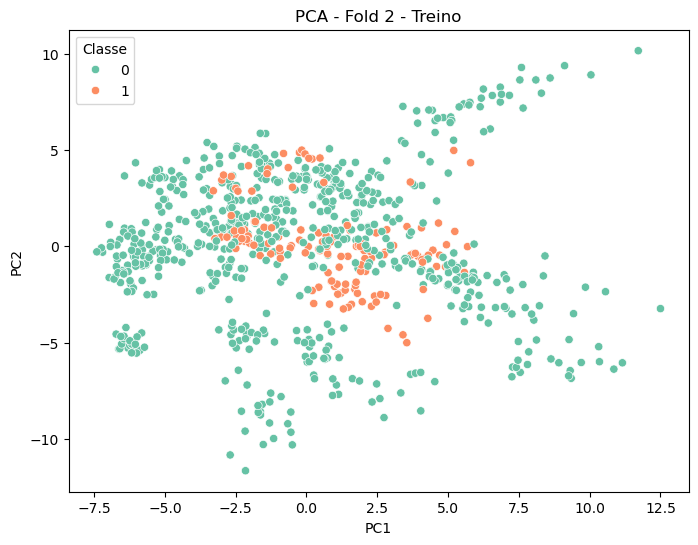

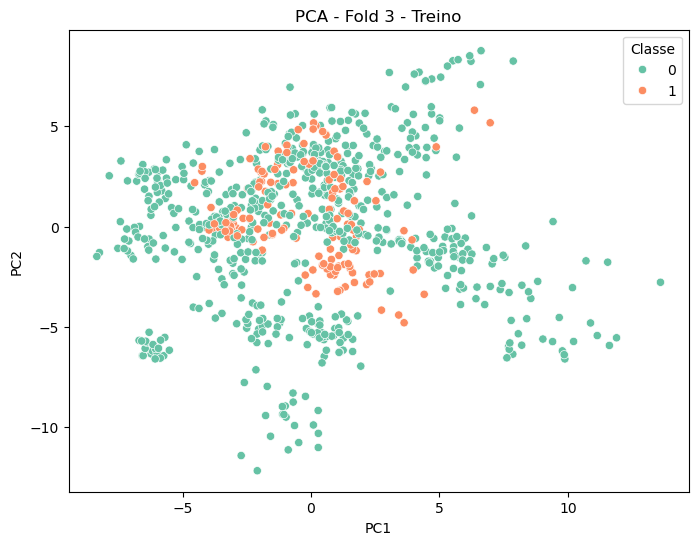

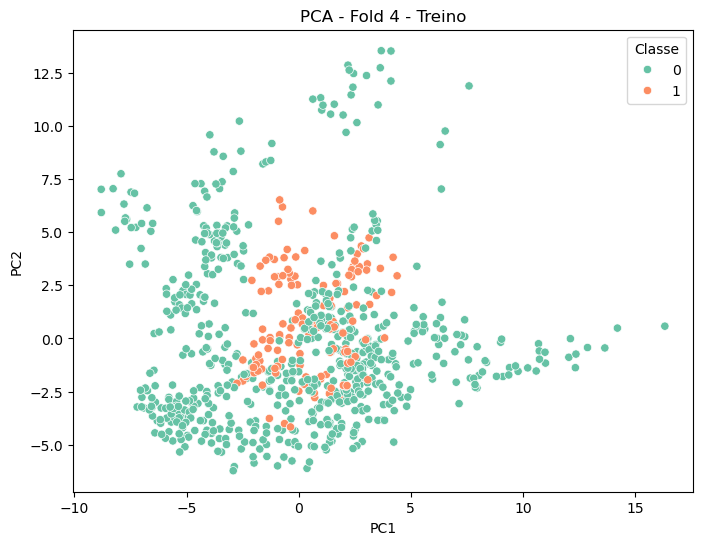

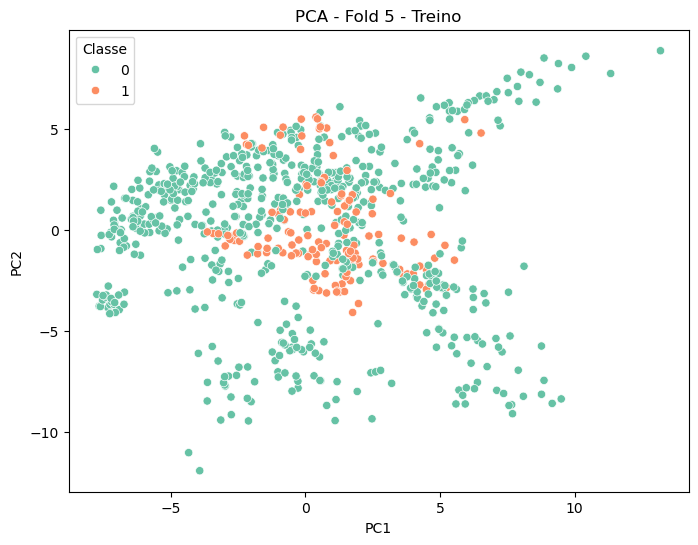

In [16]:
for fold in folds:
     Xf_pca = PCA(n_components=2).fit_transform(fold['X_train'])
     plt.figure(figsize=(8, 6))
     plt.title(f"PCA - Fold {fold['fold']} - Treino")
     sns.scatterplot(x=Xf_pca[:,0], y=Xf_pca[:,1], hue=fold['y_train'], palette="Set2")
     plt.xlabel("PC1")
     plt.ylabel("PC2")
     plt.legend(title="Classe")
     plt.show()


In [36]:
numeric_cols = df_train_split.select_dtypes(
    include=["float64", "int"]).columns.drop("window_id", errors="ignore")

X_scaled = StandardScaler().fit_transform(df_train_split[numeric_cols])

#### **UMAP e t-SNE para separação não-linear**

- O StandardScaler é aplicado para normalizar os dados antes da redução dimensional.

- Um PCA inicial com 30 componentes foi utilizado antes do t-SNE para reduzir ruído e acelerar o processo.

- O t-SNE foi aplicado com:

     - `n_components=2`: projetando os dados para duas dimensões.

     - `perplexity=30`: define o tamanho do “contexto” considerado localmente em torno de cada ponto (ajuste fino de agrupamentos).

t-SNE sem PCA pode se perder em ruído. PCA --> t-SNE é uma estratégia clássica para manter estrutura relevante e reduzir overfitting visual.

##### UMAP 2D (split fixo)

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



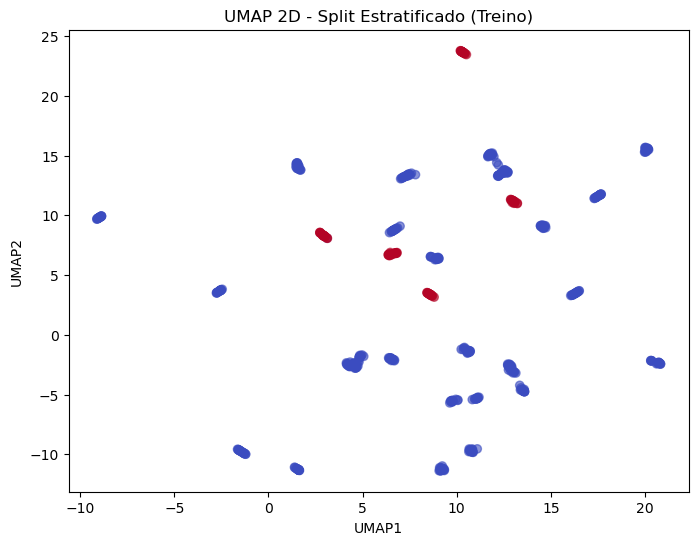

In [43]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.title("UMAP 2D - Split Estratificado (Treino)")
plt.scatter(X_umap[:, 0], X_umap[:, 1],
            c=y_train_split, cmap='coolwarm', alpha=0.6)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

##### UMAP 2D (por fold)

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



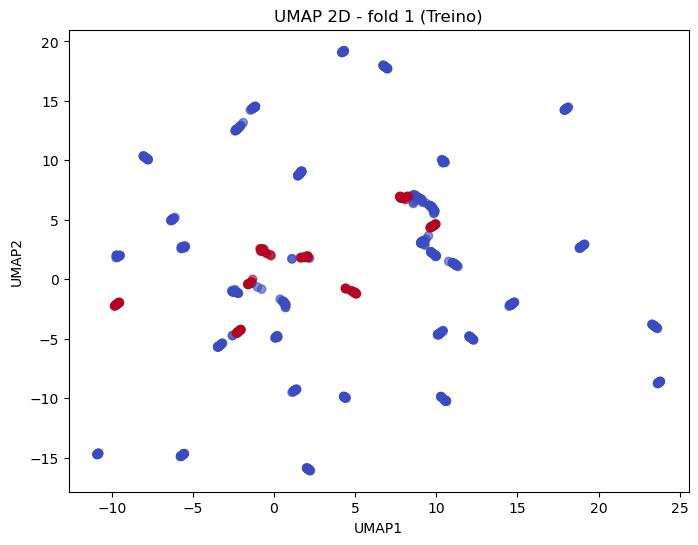

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



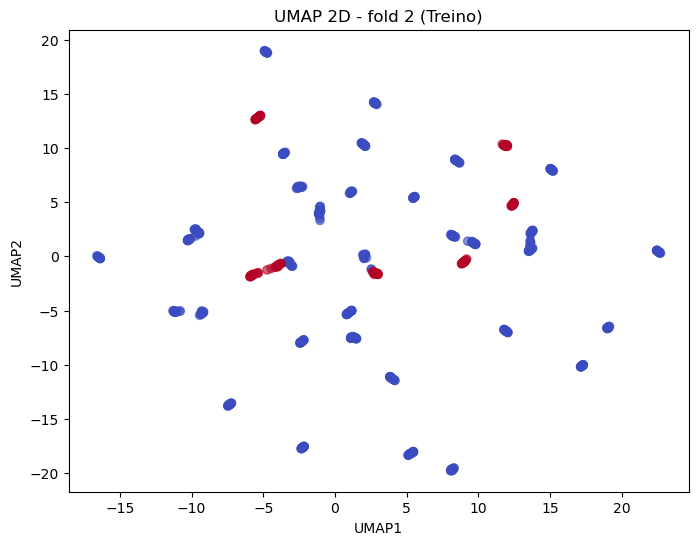

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



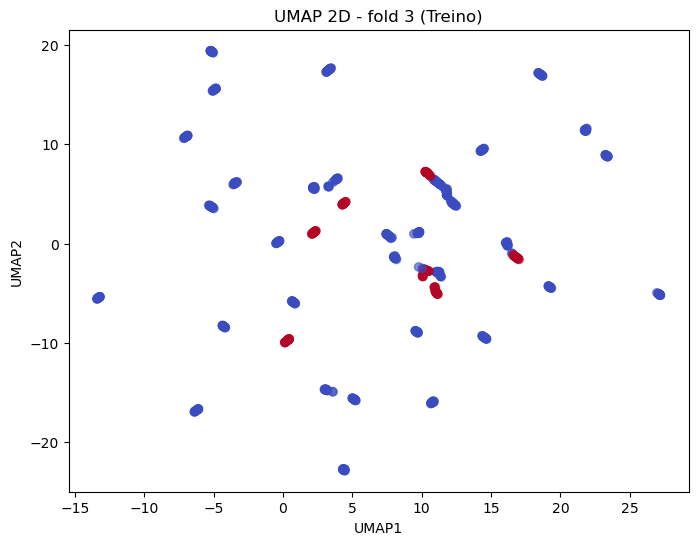

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



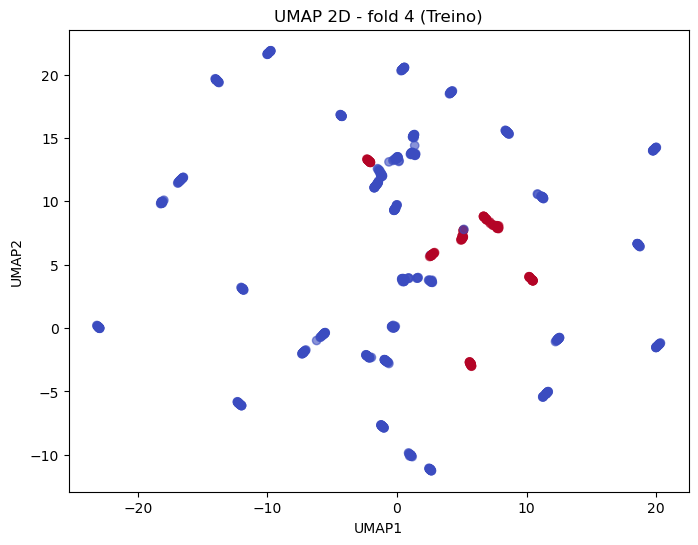

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



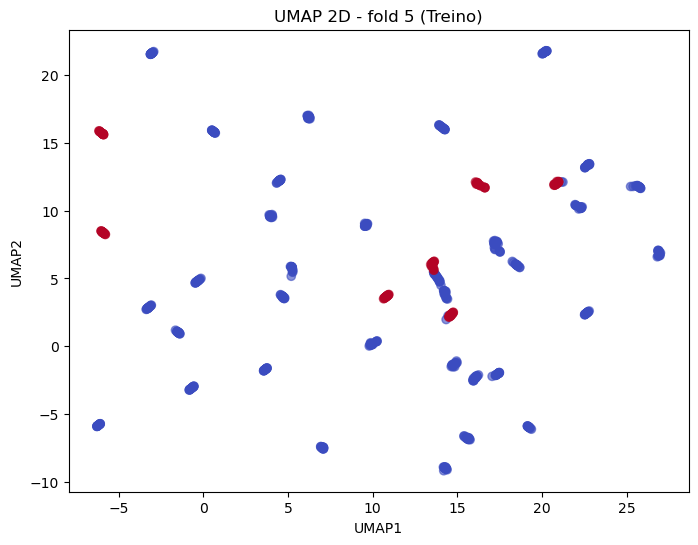

In [46]:
for fold in folds:
    Xf_umap = reducer.fit_transform(fold['X_train'])
    
    plt.figure(figsize=(8, 6))
    plt.title(f"UMAP 2D - fold {fold['fold']} (Treino)")
    plt.scatter(Xf_umap[:, 0], Xf_umap[:, 1],
                c=fold['y_train'], cmap='coolwarm', alpha=0.6)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.show()

##### t-SNE 2D (split fixo)

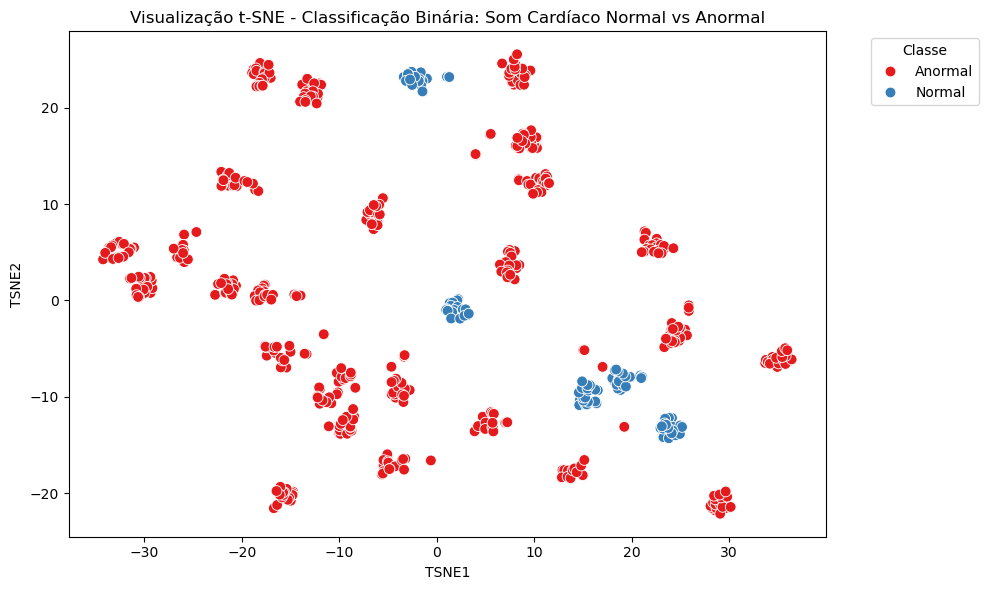

In [40]:
df = df_train_split.copy()

X = df.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")

if "Heart Sound Type_Normal" in df.columns:
    df["label"] = df["Heart Sound Type_Normal"].map(
        {0: "Anormal", 1: "Normal"})
    y = df["label"]
else:
    raise ValueError("Coluna 'Heart_Sound_Type_Normal' não encontrada.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Redução de dimensionalidade com PCA antes do t-SNE
pca = PCA(n_components=10)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_split_scaled)

df["TSNE1"] = X_tsne[:, 0]
df["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2",
                hue="label", palette="Set1", s=60)
plt.title(
    "Visualização t-SNE - Classificação Binária: Som Cardíaco Normal vs Anormal")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### t-SNE em 3D

In [ ]:

df = df_train_split.copy()

label_col = [c for c in df.columns if c.startswith("Heart Sound Type_")]
df["label"] = df[label_col].idxmax(axis=1)

# Separar features numéricas
X = df.select_dtypes(include="number").drop(
    columns=["window_id"], errors="ignore")
X = X.drop(columns=label_col, errors="ignore")

# Normalização
X_scaled = StandardScaler().fit_transform(X)

# t-SNE em 3D
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df["tsne_1"] = X_tsne[:, 0]
df["tsne_2"] = X_tsne[:, 1]
df["tsne_3"] = X_tsne[:, 2]

fig = px.scatter_3d(df, x="tsne_1", y="tsne_2", z="tsne_3", color="label",
                    title="t-SNE (3D) - Separação por tipo de som cardíaco",
                    opacity=0.8)
fig.show()

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
df_train_split = df_train_split.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std' ], errors='ignore')

df_train_split_scaled = df_train_split_scaled.drop(
    columns=['rqa_fs_mean', 'rqa_delay_mean', 'rqa_embedding_dim_mean', 'rms_energy_std'], errors='ignore')

In [52]:
df_train_split.columns

Index(['Heart Sound ID', 'window_id', 'freq_mean', 'centro_x_mean',
       'centro_y_mean', 'raio_medio_mean', 'raio_std_mean', 'raio_max_mean',
       'raio_min_mean', 'simetria_x_mean', 'simetria_y_mean',
       'densidade_nucleo_mean', 'comprimento_curva_mean',
       'variacao_curvatura_mean', 'mudanca_media_direcao_mean',
       'entropia_raio_mean', 'auto_intersecoes_mean', 'mfcc_0_mean',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'rqa_recurrence_rate_mean', 'rqa_determinism_mean',
       'rqa_average_diagonal_line_mean', 'rqa_longest_diagonal_line_mean',
       'rqa_entropy_diagonal_lines_mean', 'rqa_laminarity_mean',
       'rqa_trapping_time_mean', 'rqa_longest_vertical_line_mean',
       'rqa_entropy_vertical_lines_mean', 'rqa_fs_mean',
       'rqa_embedding_dim_mean', 'rqa_delay_mean', 'rqa_rqa_threshold_mean'

In [60]:
df = df_train_split.copy()
top_vars = desc.head(22).index.tolist()

anova_binaria = {}

y = df_train_split["Heart Sound Type_Normal"]

for var in top_vars:
    grupo_normal = df[df["Heart Sound Type_Normal"] == 1][var].dropna(
    )
    grupo_anormal = df[df["Heart Sound Type_Normal"]
                               == 0][var].dropna()

    if len(grupo_normal) >= 2 and len(grupo_anormal) >= 2:
        try:
            pval = f_oneway(grupo_normal, grupo_anormal).pvalue
            anova_binaria[var] = pval
        except Exception as e:
            print(f"Erro com {var}: {e}")
    else:
        print(f"Variável ignorada: {var} (amostras insuficientes)")

anova_binaria_sorted = dict(sorted(anova_binaria.items(), key=lambda x: x[1]))

In [61]:
anova_binaria_sorted

{'mfcc_11_mean': np.float64(5.437605647446237e-20),
 'mfcc_5_mean': np.float64(2.96932286321955e-13),
 'mfcc_6_mean': np.float64(3.1658276712921523e-12),
 'mfcc_10_mean': np.float64(5.981709426162654e-10),
 'mfcc_12_mean': np.float64(8.641415616517434e-10),
 'mfcc_2_mean': np.float64(2.241567779230638e-09),
 'mfcc_3_mean': np.float64(1.2256220999315055e-08),
 'spectral_centroid_mean': np.float64(2.747578054593789e-07),
 'freq_std': np.float64(4.519426275911533e-06),
 'freq_mean': np.float64(5.039997614192798e-05),
 'rqa_longest_diagonal_line_mean': np.float64(0.0020929396354588273),
 'mfcc_8_mean': np.float64(0.004228675269783627),
 'auto_intersecoes_std': np.float64(0.005769008520704557),
 'mfcc_1_mean': np.float64(0.031397223448434305),
 'kurtosis_mean': np.float64(0.04558969921192295),
 'mfcc_9_mean': np.float64(0.07157410017936437),
 'comprimento_curva_mean': np.float64(0.1455555736361532),
 'mfcc_0_mean': np.float64(0.23176025119754018),
 'auto_intersecoes_mean': np.float64(0.3936

In [24]:
del df_agg_cod['window_id']
del df_agg_cod_norm['window_id']

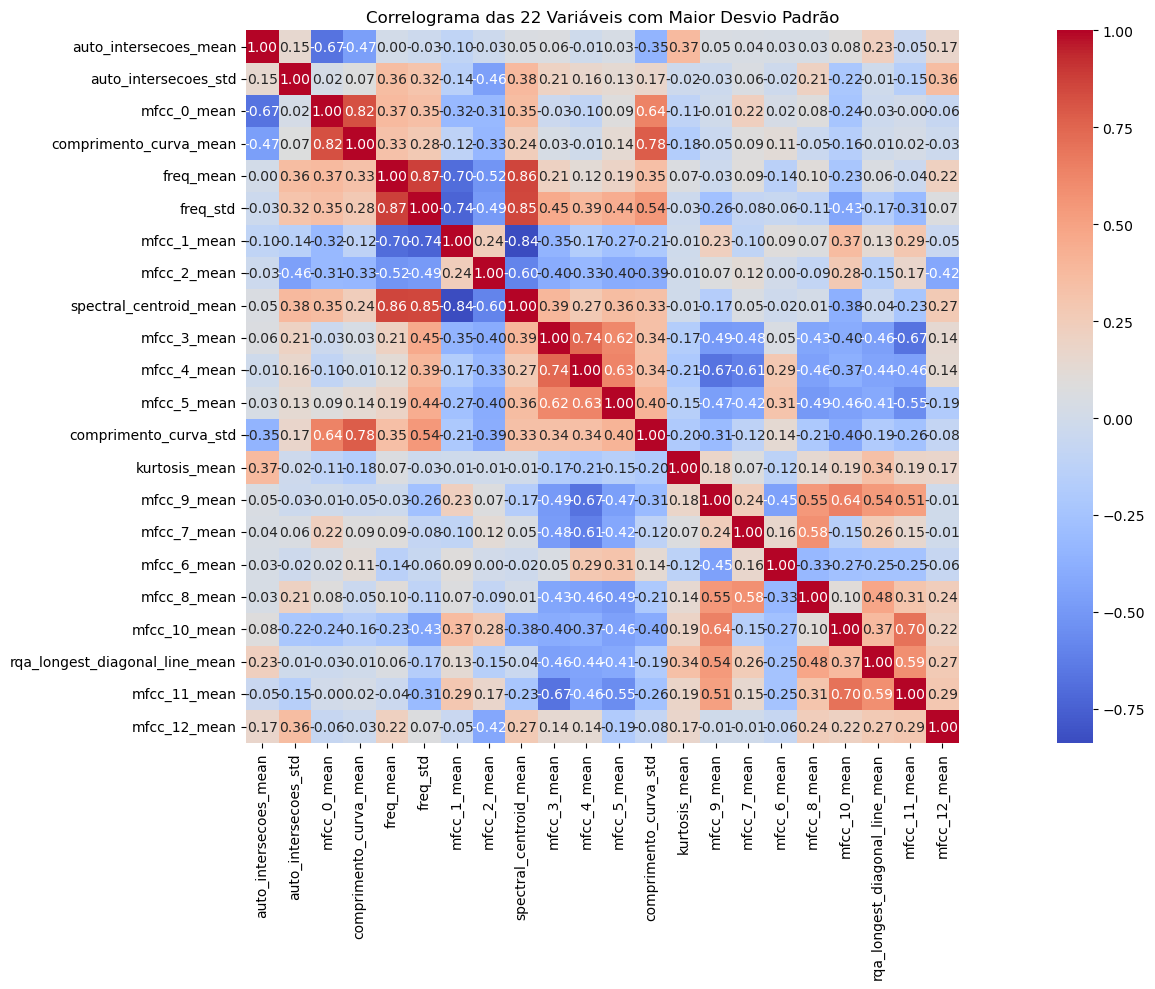

O Heatmap de correlação de Pearson entre as 22 variáveis com maior desvio padrão do dataset agregado por janela nos diz que há alta correlação (redundância potencial) entre:

* `mfcc_0_mean`:
     * `comprimento_curva_mean` (r=0.83)
     * `comprimento_curva_std` (r=0.61)

* `freq_mean`:
     * `freq_std` (r=0.77)
     * `spectral_centroid_mean` (r=0.92)

* `mfcc_3_mean`:
     * `mfcc_4_mean` (r=0.70)

* `mfcc_9_mean`:
     * `mfcc_10_mean` (r=0.65)


DECISÃO PROVISÓRIA: 
- deletar as _features_ de maior correlação com outras:


In [26]:
df_agg_cod = df_agg_cod.drop(
    columns=['freq_mean', 'comprimento_curva_mean', 'has_trapping_mean', 'freq_std'], errors='ignore')
desc = df_agg_cod.describe().T.sort_values("std", ascending=False)

In [27]:
# Como Gender_M e Gender_F são inversamente correlacionados, é interessante deletar um desses atributos
del df_agg_cod['Gender_M']

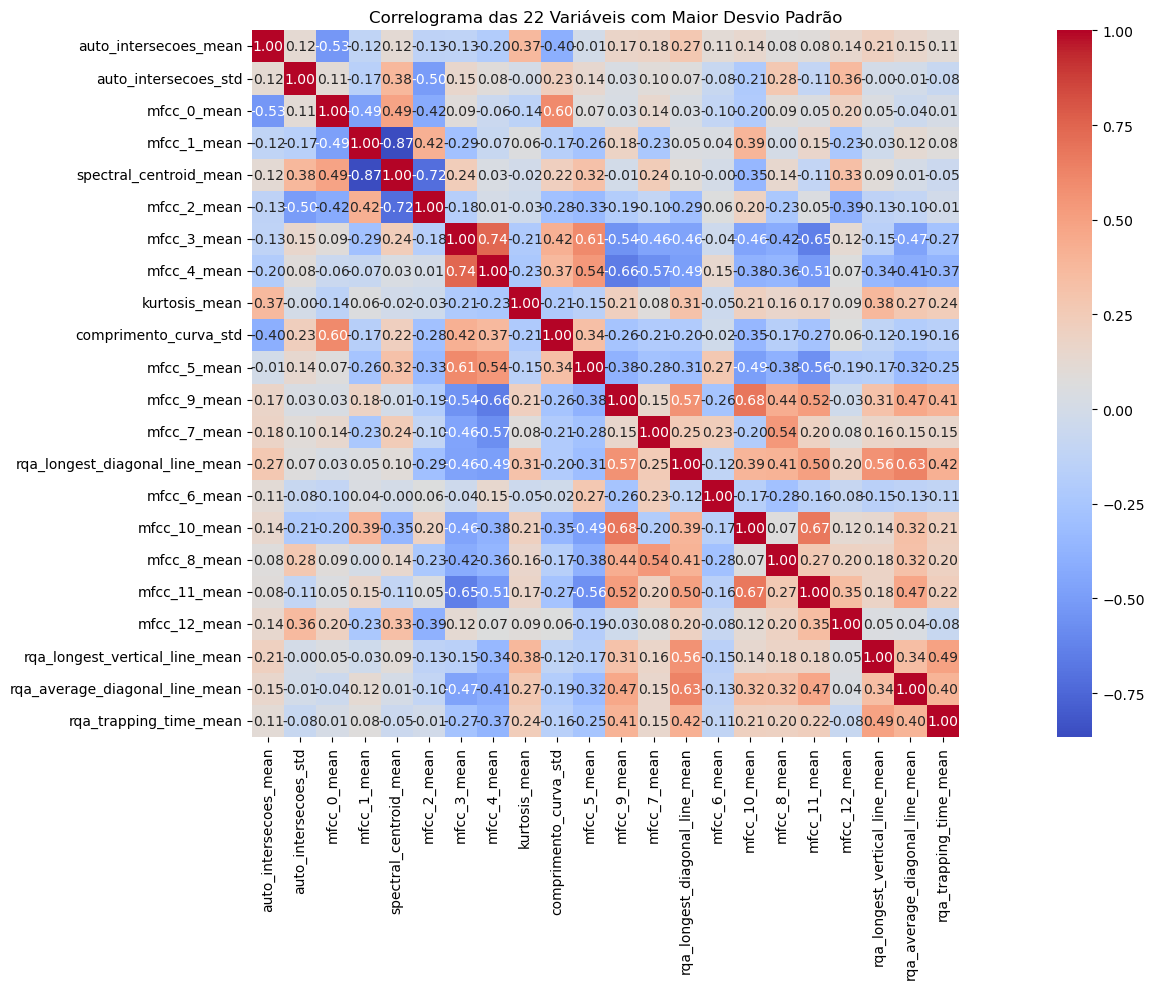

In [28]:
top_vars = desc.head(22).index.tolist()
corr = df_agg_cod[top_vars].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlograma das 22 Variáveis com Maior Desvio Padrão")
plt.tight_layout()
plt.show()

In [105]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Copiar base
# df_features = df_agg_cod.copy()

# # Identificar MFCCs
# mfcc_cols = [
#     col for col in df_features.columns if "mfcc_" in col and "_mean" in col]

# # OUTRA FEATURES: manter apenas colunas numéricas úteis (sem redundâncias e constantes)
# non_mfcc_cols = [
#     col for col in df_features.select_dtypes(include=["float64", "int"]).columns
#     if col not in mfcc_cols + ["window_id"] and not col.endswith("_std")
# ]

# # X_A: versão com MFCCs selecionados manualmente (os menos correlacionados)
# mfcc_selected = ["mfcc_0_mean", "mfcc_3_mean", "mfcc_9_mean"]
# X_A = df_features[mfcc_selected + non_mfcc_cols].copy()

# # X_B: versão com PCA nos MFCCs (3 componentes)
# scaler = StandardScaler()
# X_mfcc_scaled = scaler.fit_transform(df_features[mfcc_cols])
# pca = PCA(n_components=3)
# X_mfcc_pca = pca.fit_transform(X_mfcc_scaled)

# # Nomear colunas PCA
# df_pca_mfcc = pd.DataFrame(
#     X_mfcc_pca, columns=["mfcc_pca_1", "mfcc_pca_2", "mfcc_pca_3"])
# df_pca_mfcc.index = df_features.index  # garantir alinhamento

# X_B = pd.concat([df_pca_mfcc, df_features[non_mfcc_cols]], axis=1)
# del X_B['has_trapping_mean']
# del X_B['freq_mean']


In [25]:
del df_agg_cod['window_id']

p-valores extremamente baixos indicam que essas variáveis são **altamente relevantes para diferenciar entre classes** de sons cardíacos. Variáveis como MFCCs, auto-interseções e métricas RQA se destacam como mais informativas.

- O StandardScaler é aplicado para normalizar os dados antes da redução dimensional.

- Um PCA inicial com 30 componentes foi utilizado antes do t-SNE para reduzir ruído e acelerar o processo.

- O t-SNE foi aplicado com:

     - `n_components=2`: projetando os dados para duas dimensões.

     - `perplexity=30`: define o tamanho do “contexto” considerado localmente em torno de cada ponto (ajuste fino de agrupamentos).

t-SNE sem PCA pode se perder em ruído. PCA --> t-SNE é uma estratégia clássica para manter estrutura relevante e reduzir overfitting visual.

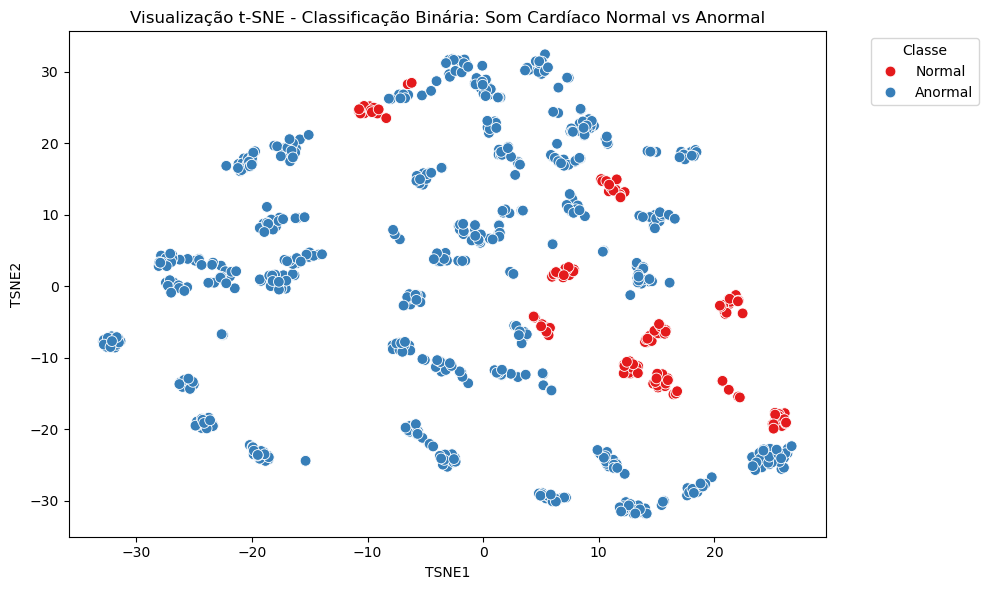

In [ ]:

df = df_agg_cod.copy()

X = df.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")

if "Heart_Sound_Type_Normal" in df.columns:
    df["label"] = df["Heart_Sound_Type_Normal"].map(
        {0: "Anormal", 1: "Normal"})
    y = df["label"]
else:
    raise ValueError("Coluna 'Heart_Sound_Type_Normal' não encontrada.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Redução de dimensionalidade com PCA antes do t-SNE
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df["TSNE1"] = X_tsne[:, 0]
df["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2",
                hue="label", palette="Set1", s=60)
plt.title(
    "Visualização t-SNE - Classificação Binária: Som Cardíaco Normal vs Anormal")
plt.legend(title="Classe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Importância das variáveis (com _RandomForest_)


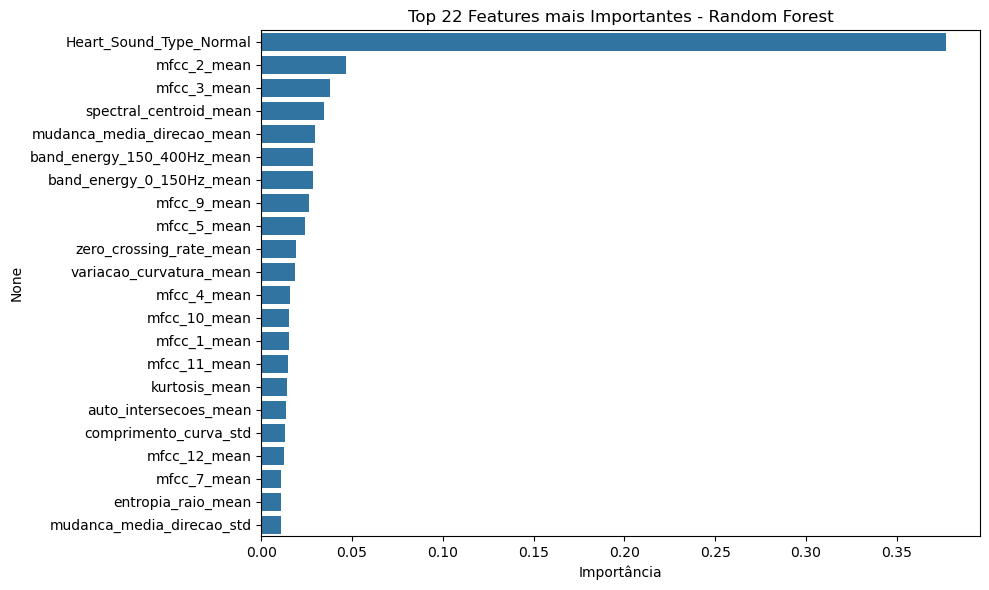

(Heart_Sound_Type_Normal       0.376936
 mfcc_2_mean                   0.046813
 mfcc_3_mean                   0.037787
 spectral_centroid_mean        0.034435
 mudanca_media_direcao_mean    0.029812
 band_energy_150_400Hz_mean    0.028557
 band_energy_0_150Hz_mean      0.028509
 mfcc_9_mean                   0.026265
 mfcc_5_mean                   0.024228
 zero_crossing_rate_mean       0.019437
 variacao_curvatura_mean       0.018848
 mfcc_4_mean                   0.015817
 mfcc_10_mean                  0.015329
 mfcc_1_mean                   0.015212
 mfcc_11_mean                  0.014969
 kurtosis_mean                 0.014463
 auto_intersecoes_mean         0.013810
 comprimento_curva_std         0.013305
 mfcc_12_mean                  0.012612
 mfcc_7_mean                   0.011152
 entropia_raio_mean            0.010884
 mudanca_media_direcao_std     0.010785
 dtype: float64,
 {'mfcc_2_mean': np.float64(1.3192790481593503e-24),
  'spectral_centroid_mean': np.float64(1.220373723

In [28]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False).head(22)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.values, y=importances_sorted.index)
plt.title("Top 22 Features mais Importantes - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

importances_sorted, anova_binaria_sorted

### ViolinPlots dos top 5 MFCCs entre 2-3 classes mais distintas

D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_13328\3071429833.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

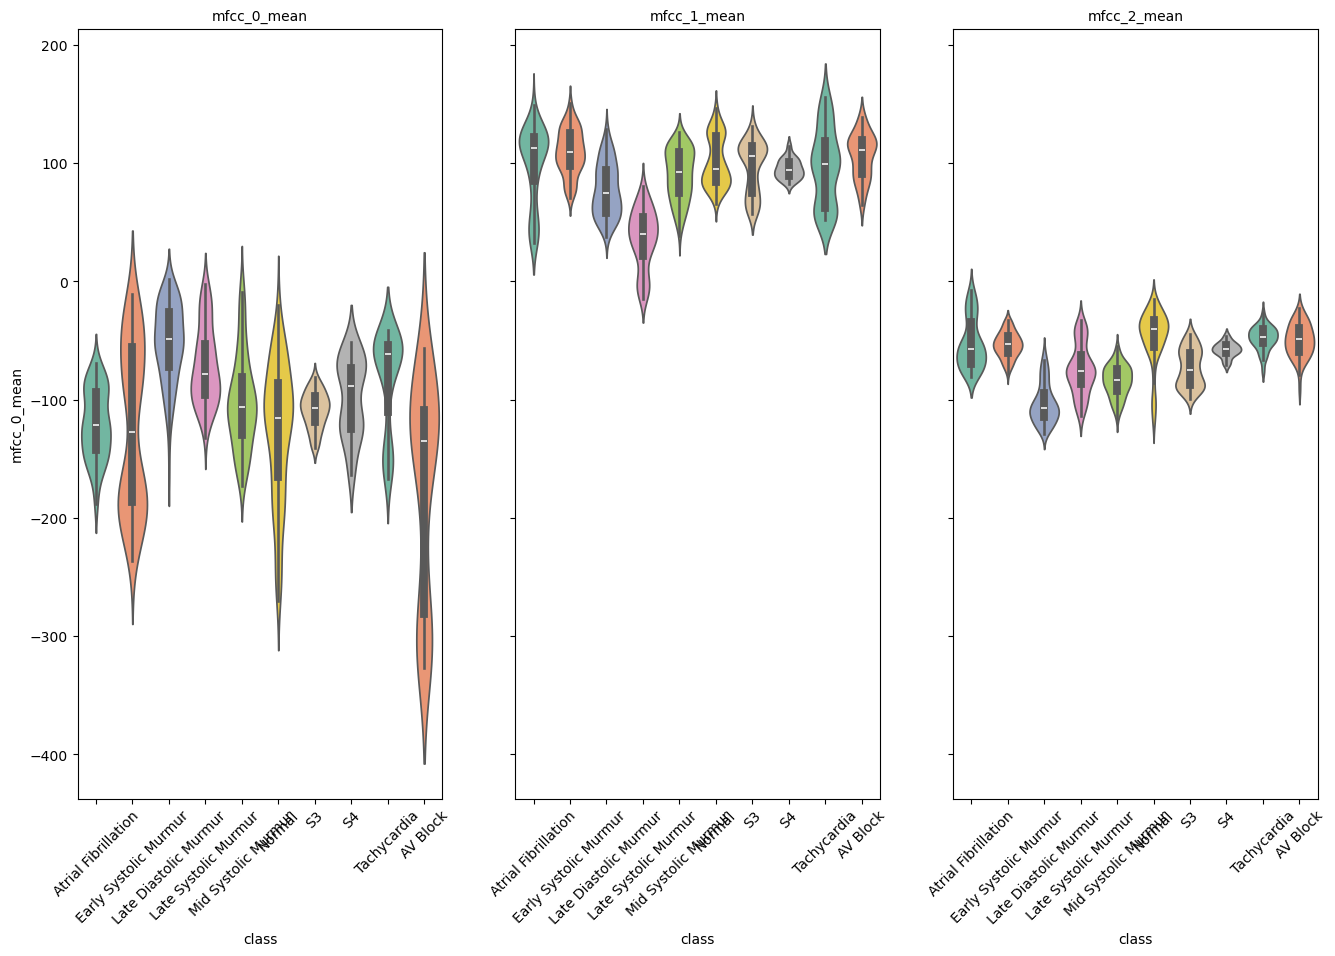

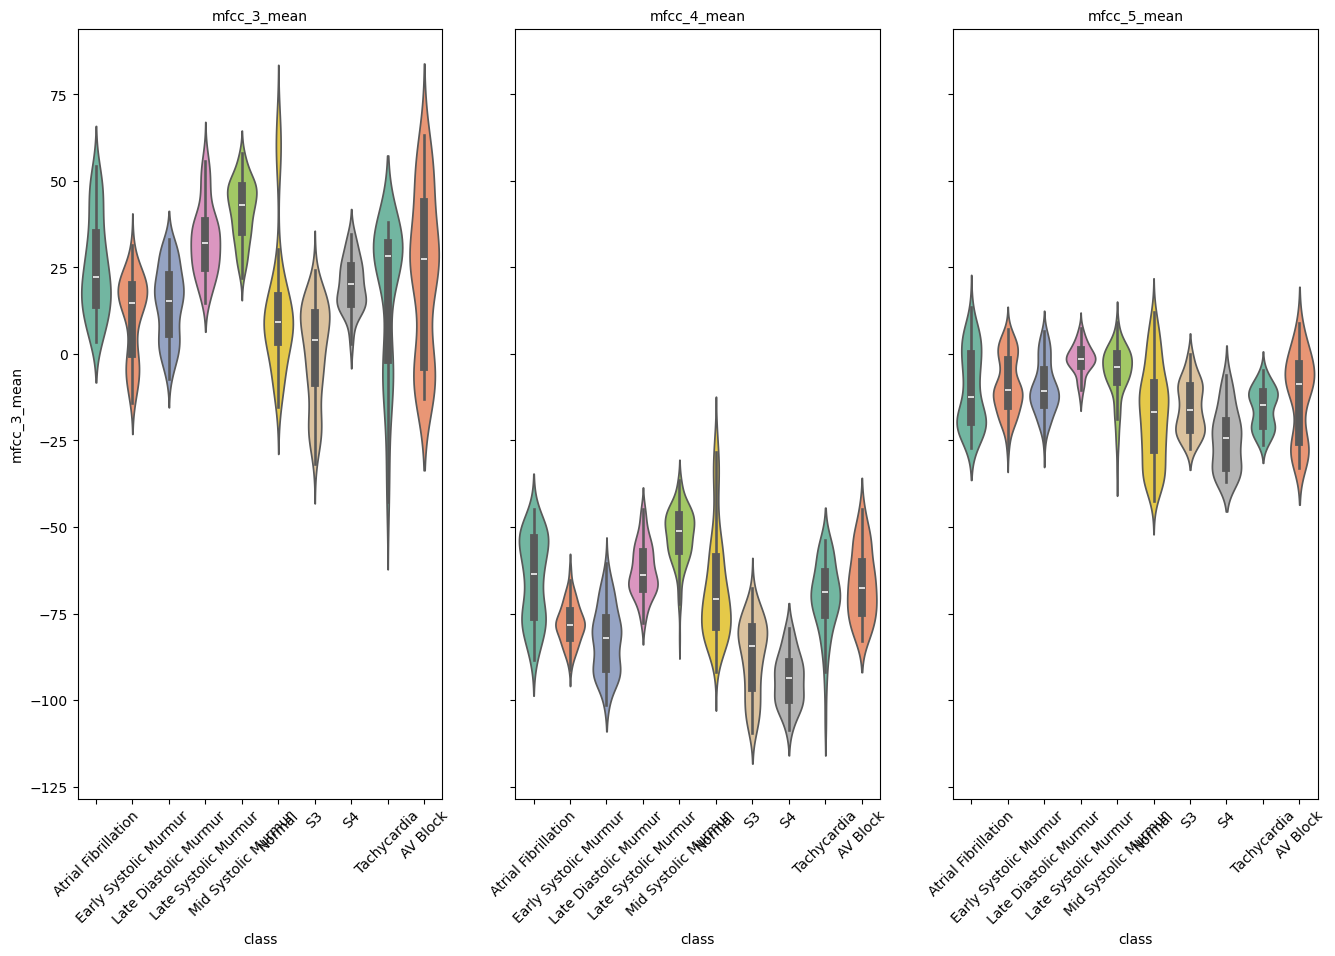

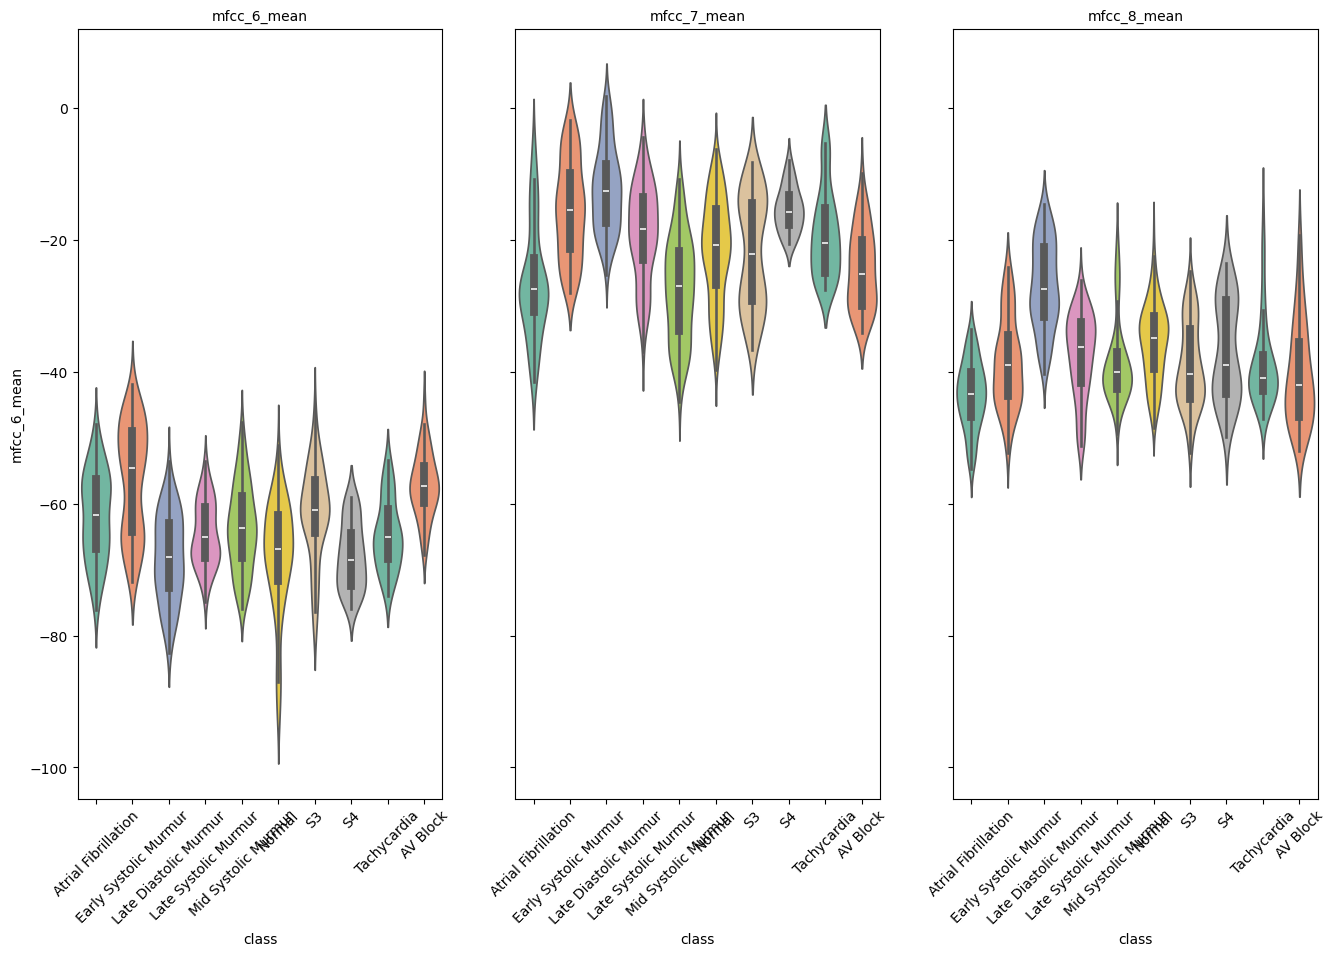

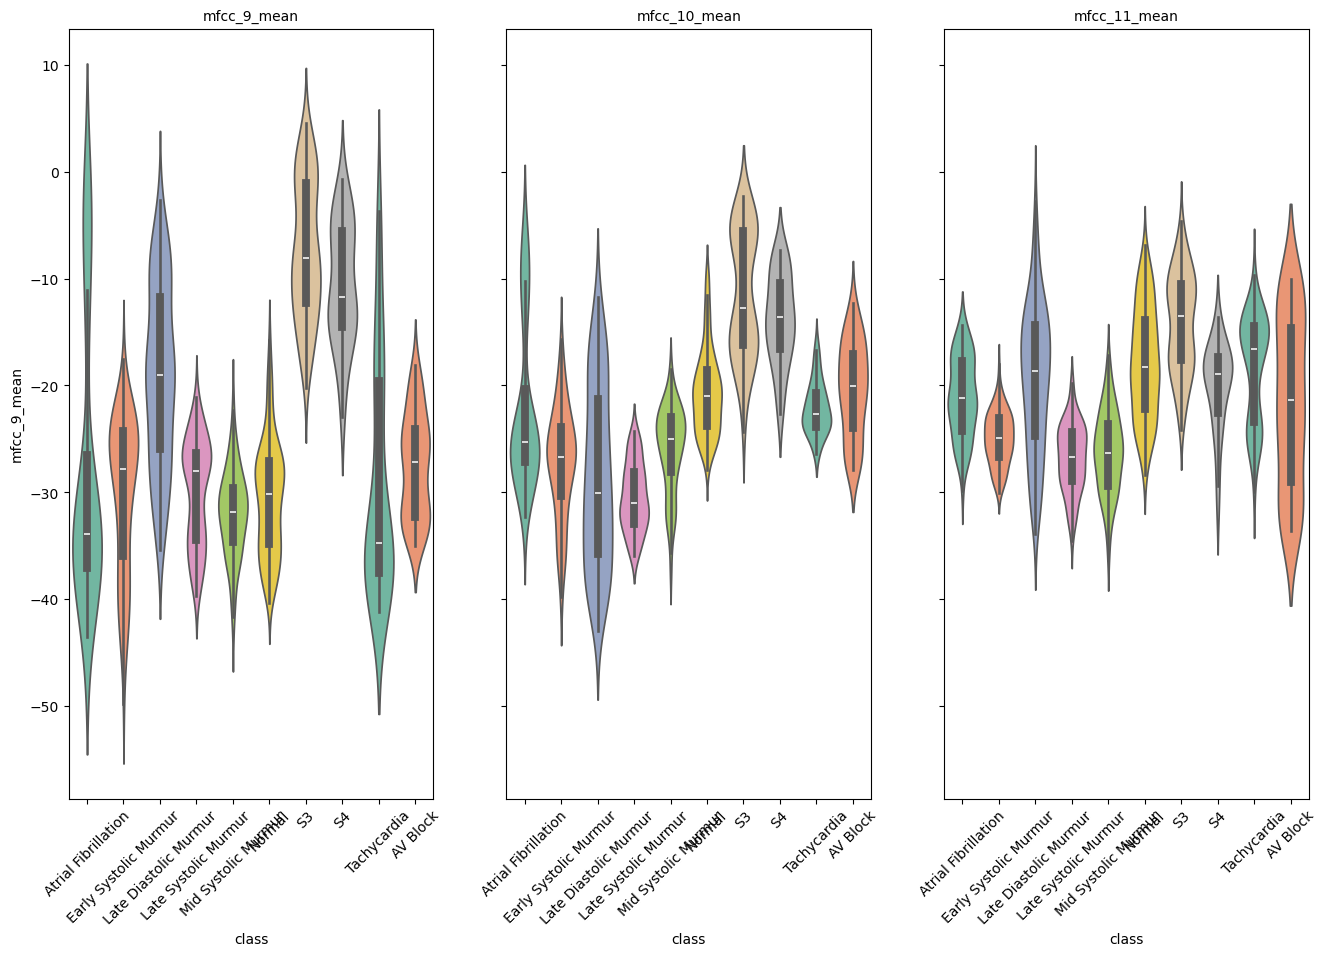

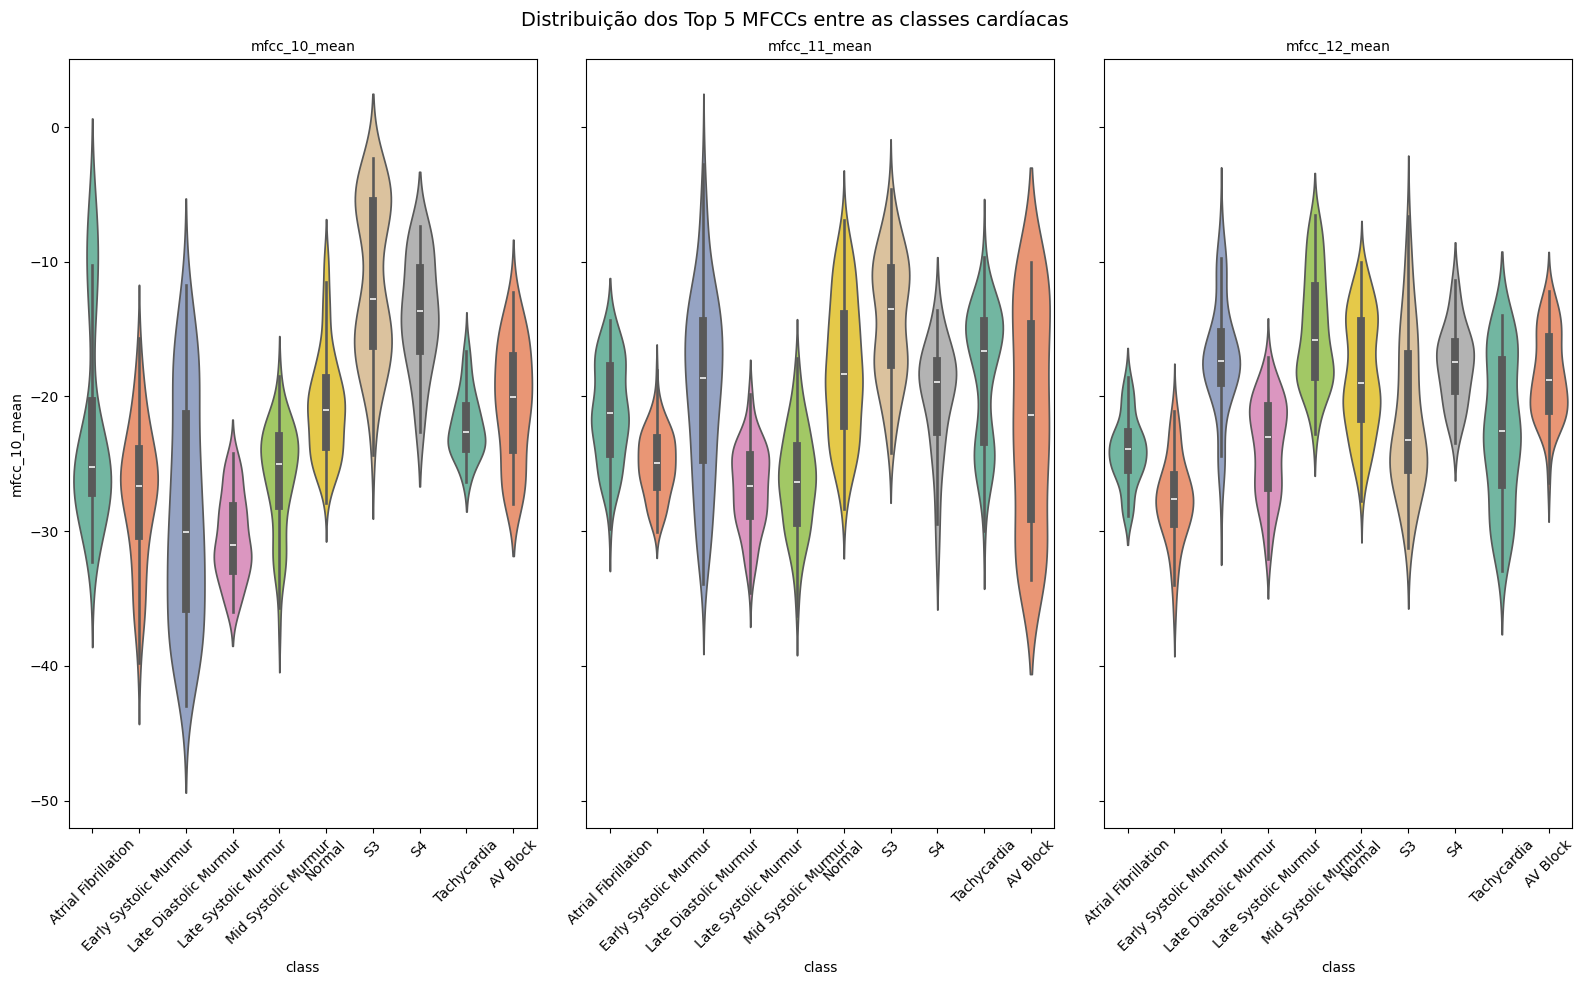

In [48]:

# Selecionar os top 5 MFCCs com base nos resultados de ANOVA anteriores
top_mfccs = ['mfcc_0_mean', 'mfcc_1_mean',
              'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
              'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean',
              'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean',
              'mfcc_11_mean', 'mfcc_12_mean']

# Nome da coluna de rótulo de classe
label_col = 'Heart Sound Type'  # nome comum antes da codificação one-hot

# Extração do nome da classe com one-hot encoding reversa
df['class'] = df.filter(like='Heart Sound Type_').idxmax(
    axis=1).str.replace('Heart Sound Type_', '')

# Plotar violinplots dos MFCCs

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[:3]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[3:6]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[6:9]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[9:12]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 10), sharey=True)
for i, mfcc in enumerate(top_mfccs[10:]):
    sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],  palette="Set2")
    axs[i].set_title(mfcc, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)


# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10), sharey=True)
# for i, mfcc in enumerate(top_mfccs[9:12]):
#     sns.violinplot(data=df, x='class', y=mfcc, ax=axs[i],)
#     axs[i].set_title(mfcc, fontsize=10)
#     axs[i].tick_params(axis='x', rotation=45)


fig.suptitle(
    'Distribuição dos Top 5 MFCCs entre as classes cardíacas', fontsize=14)
plt.tight_layout()
plt.show()

D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


D:\Users\pflss\AppData\Local\Temp\ipykernel_29028\1175229633.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

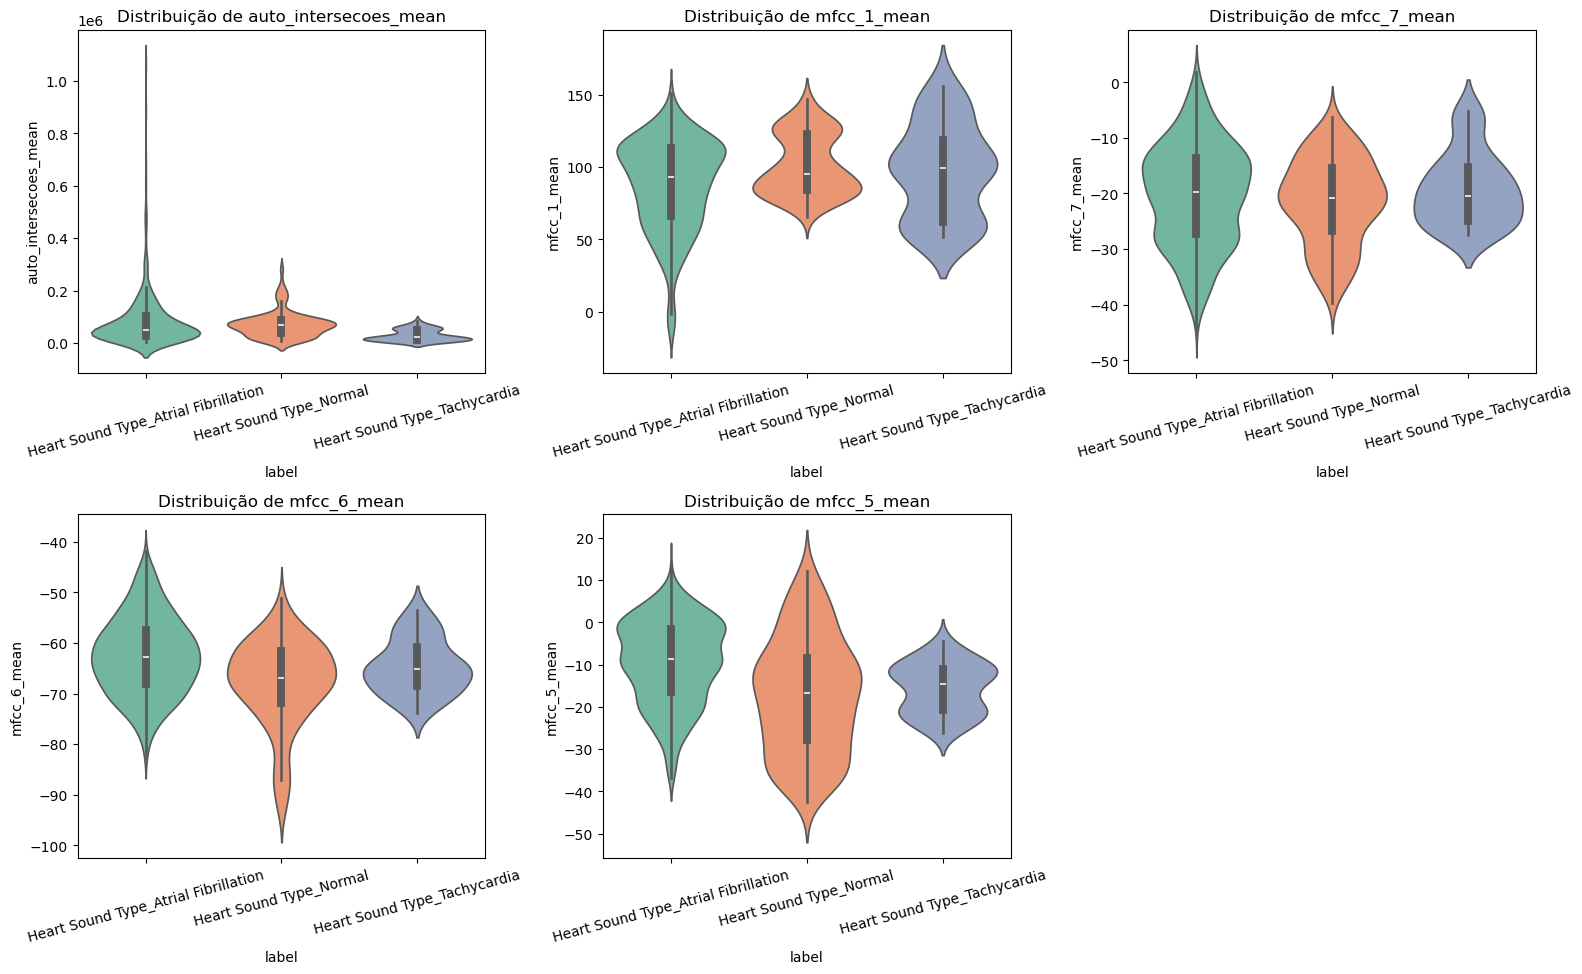

In [ ]:

df = df_agg_cod.copy()

# Determinar os top 5 MFCCs a partir dos resultados do ANOVA
top_mfccs = ['mfcc_3_mean', 'mfcc_1_mean',
             'mfcc_7_mean', 'mfcc_6_mean', 'mfcc_5_mean']

# Selecionar apenas classes de interesse (AFib, Normal, e uma terceira distinta)
classes_selecionadas = [
    'Heart Sound Type_Atrial Fibrillation',
    'Heart Sound Type_Normal',
    'Heart Sound Type_Tachycardia'
]

# Adicionar coluna de rótulo unificado
df["label"] = df[classes_selecionadas].idxmax(axis=1)

# Gerar os violinplots
plt.figure(figsize=(16, 10))
for i, col in enumerate(top_mfccs, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df, x="label", y=col, palette="Set2")
    plt.title(f"Distribuição de {col}")
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()